<span>
<img src="img/cdlib_new.png" width="120px" align="right"/>
</span>
<span>
<b>Author:</b> <a href="http://about.giuliorossetti.net">Giulio Rossetti</a><br/>
<b>Python version:</b>  3.7<br/>
<b>CDlib version:</b>  0.1.10<br/>
<b>Last update:</b> 16/02/2021
</span>

In [1]:
import warnings
from collections import Counter
import numpy as np
warnings.filterwarnings('ignore')

<a id='top'></a>
# *Chapter 8: Community Discovery*

In this notebook are introduced the main steps for the extraction and topological analysis of communities.

**Note:** this notebook is purposely not 100% comprehensive, it only discusses the basic things you need to get started. For all the details, algorithm/methods/evaluation facilities available in ``CDlib``, please refer to the official [documentation](https://cdlib.readthedocs.io) and the dedicated notebook appendix.

## Table of Contents

1. [Community Discovery Workflow](#workflow)
    1. [Graph Creation](#graph)
    2. [Community Discovery algorithm(s) selection and configuration ](#model)
    3. [Clustering Evaluation (Fitness functions)](#fitness)
    4. [Clustering Evaluation (Comparison)](#comparison)
    5. [Community/Statistics Visualization](#visualization)
    5. [Qualitative evaluation](#qualitative)
    7. [Ground Truth evaluation](#gt)

In [ ]:
!pip install cdlib

In [3]:
import cdlib

In [ ]:
!unzip asioaf.zip

<a id='workflow'></a>
## Community Discovery Workflow ([to top](#top))

The standard workflow can be summarized as:
- Network Creation
- Community Discovery algorithm(s) selection and configuration
- Clustering(s) evaluation (Fitness functions)
- Clustering(s) evaluation (Comparisons)
- Community/Statistics Visualization

In this section we will observe how to templating such workflow applying two classic network clustering algorithms: Label Propagation and Leiden.
All analysis will be performed using ``CDlib``.

<a id="graph"></a>
### Graph object creation ([to top](#top))

As a first step we need to define the network topology that will be used as playground to study diffusive phenomena.

``CDlib`` natively supports both [``networkx``](https://networkx.github.io) and [``igraph``](https://igraph.org/python/) data structures.

In our examples, for the sake of simplicity, we will use ``networkx`` undirected graphs.

In [ ]:
import networkx as nx

def read_net(filename):
    g = nx.Graph()
    with open(filename) as f:
        f.readline()
        for l in f:
            l = l.split(",")
            g.add_edge(l[0], l[1])
    return g

# Game of Thrones Season
season = 1
g = read_net(f'asioaf/got-s{season}-edges.csv')

<a id="model"></a>
### Community Discovery algorithm(s) selection and configuration ([to top](#top))

After having defined the graph, we can select the algorithm(s) to partition it.

In [ ]:
from cdlib import algorithms

In [ ]:
lp_coms = algorithms.label_propagation(g)

In [ ]:
!pip install igraph
!pip install leidenalg

In [ ]:
leiden_coms = algorithms.leiden(g)

All Community Discovery algorithms generate as result an object that implements a concrete instance of the ``Clustering`` datatype.

In particular, both Louvain and Label Propagation returns a ``NodeClustering`` object having the following propterties:

In [ ]:
leiden_coms.method_name # Clustering algorithm name

'Leiden'

In [ ]:
leiden_coms.method_parameters # Clustering parameters

{'initial_membership': None, 'weights': None}

In [ ]:
leiden_coms.communities # Identified Clustering

In [ ]:
leiden_coms.overlap # Wehter the clustering is overlapping or not

False

In [ ]:
leiden_coms.node_coverage # Percentage of nodes covered by the clustering

1.0

Moreover, ``Clustering`` object allow also for the generation of a JSON representation of the results

In [ ]:
leiden_coms.to_json()

'{"communities": [["NED", "ROBERT", "LITTLEFINGER", "VARYS", "ARYA", "CERSEI", "JOFFREY", "SANSA", "PYCELLE", "SEPTA_MORDANE", "LORAS", "RENLY", "SYRIO_FOREL", "JORY_CASSEL", "ROS", "BARRISTAN", "YOREN", "HOUND", "LANCEL", "JANOS", "GENDRY", "HOT_PIE", "LOMMY_GREENHANDS", "MERYN_TRANT", "JON_ARRYN", "STANNIS", "MYCAH", "TOBHO_MOTT", "MHAEGEN", "BAELOR", "STABLE_BOY", "HUGH_OF_THE_VALE", "MOUNTAIN", "TOMARD", "ILYN_PAYNE", "LYANNA", "BERIC", "HIGH_SEPTON", "TOMMEN", "MACE", "ROOSE_BOLTON", "STEFFON", "VARLY"], ["ROBB", "THEON", "BRAN", "MAESTER_LUWIN", "WALDER", "GREATJON_UMBER", "OSHA", "RICKON", "HODOR", "OLD_NAN", "GARED", "ROYCE", "JONOS_BRACKEN", "WILL", "RYGER_RIVERS", "STEVRON_FREY", "WAYMAR_ROYCE", "ASSASSIN", "BALON", "HOSTER", "GALBART_GLOVER", "RICKARD_KARSTARK", "JOYEUSE"], ["CATELYN", "BRONN", "TYRION", "SHAE", "TYWIN", "MORD", "LYSA", "ROBIN", "RODRIK", "SHAGGA", "MARILLION", "KEVAN", "VARDIS_EGEN", "MASHA_HEDDLE", "ADDAM_MARBRAND", "LEO_LEFFORD", "MYRCELLA", "JOANNA"], ["

<a id="fitness"></a>
### Clustering Evaluation (Fitness functions) ([to top](#top))

After having obtained a network clustering we can compute several indexes upon it.

For a same index it is possible to obtain a synthetic representation of its min/max/mean/std values

In [ ]:
leiden_coms.average_internal_degree()

FitnessResult(min=2.0, max=8.465116279069768, score=5.320107236243559, std=1.9901175346179403)

as well as its communitiy-wise value

In [ ]:
leiden_coms.average_internal_degree(summary=False)

[8.465116279069768,
 3.9130434782608696,
 5.777777777777778,
 6.0,
 5.764705882352941,
 2.0]

Fitness scores can also be instantiated at library level

In [ ]:
from cdlib import evaluation

evaluation.average_internal_degree(g, leiden_coms)

FitnessResult(min=2.0, max=8.465116279069768, score=5.320107236243559, std=1.9901175346179403)

For the complete list of implemented fitness functions, refer to the online [documentation](https://cdlib.readthedocs.io/en/latest/reference/evaluation.html).

<a id="comparison"></a>
### Clustering Evaluation (Comparison) ([to top](#top))

When multiple clustering have been computed on a same network it is useful to measure their resemblance.

``CDlib`` allows to do so by exposing several clustering resemblance scores, each one of them tailored to support specific kind of network clusterings (crisp/partition, complete/partial node coverage).

As for the fitness functions, resemblance scores can be instantiated at the community level as well as at the library level.

In [ ]:
leiden_coms.normalized_mutual_information(lp_coms)

MatchingResult(score=0.5869626527176506, std=None)

In [ ]:
evaluation.normalized_mutual_information(leiden_coms, lp_coms)

MatchingResult(score=0.5869626527176506, std=None)

<a id="visualization"></a>
### Community/Statistics Visualization ([to top](#top))

``CDlib`` allows to generate two families of predefined plots:
- network/community visualizations
- community fitness/comparison visualizations

#### Graph visualization

One way to visualize the communities identified on a graph is by coloring graph nodes accordingly

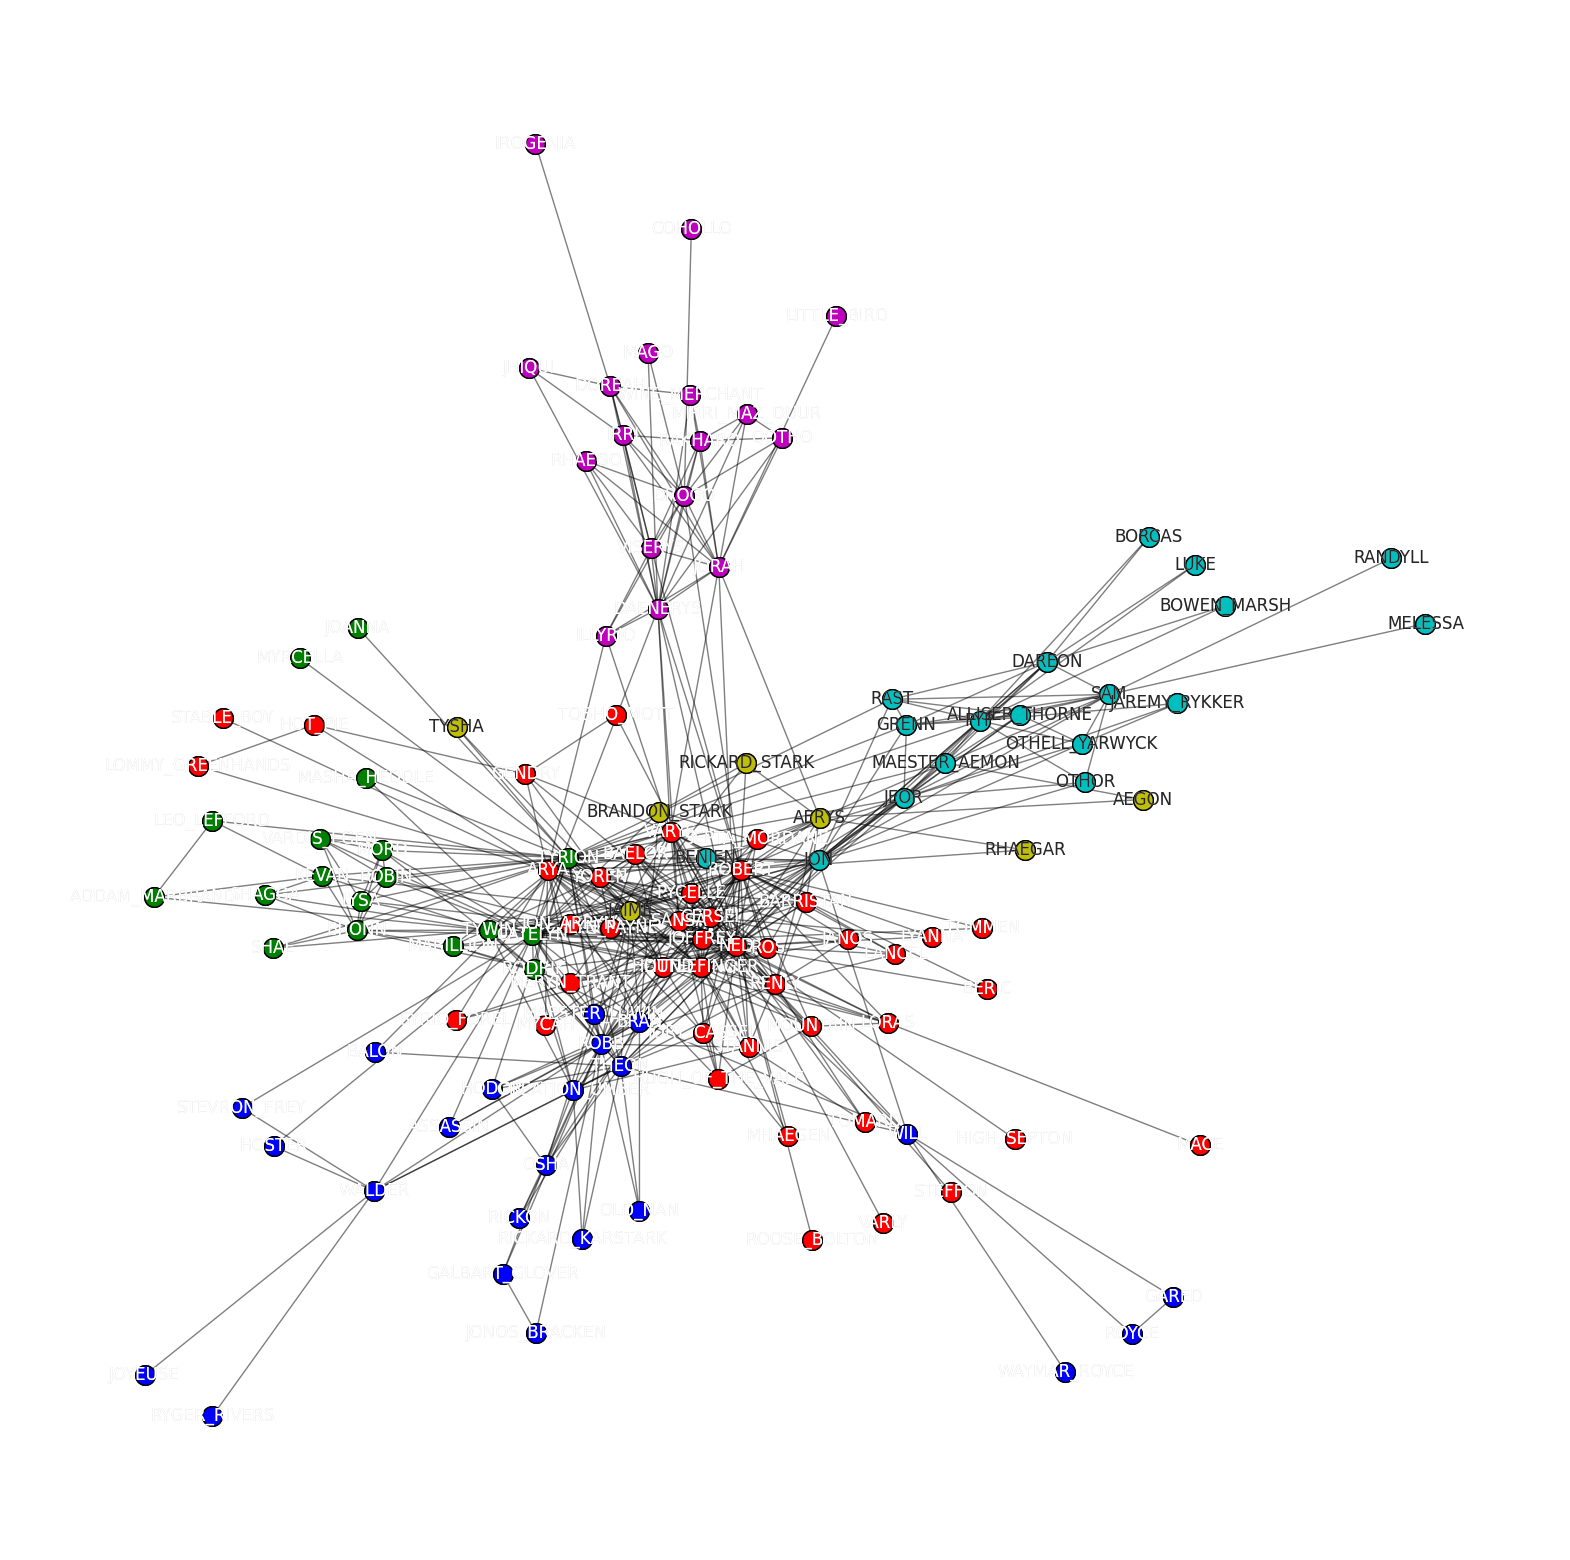

In [ ]:
from cdlib import viz

pos = nx.spring_layout(g)
viz.plot_network_clusters(g, leiden_coms, pos, figsize=(20, 20), plot_labels=True)

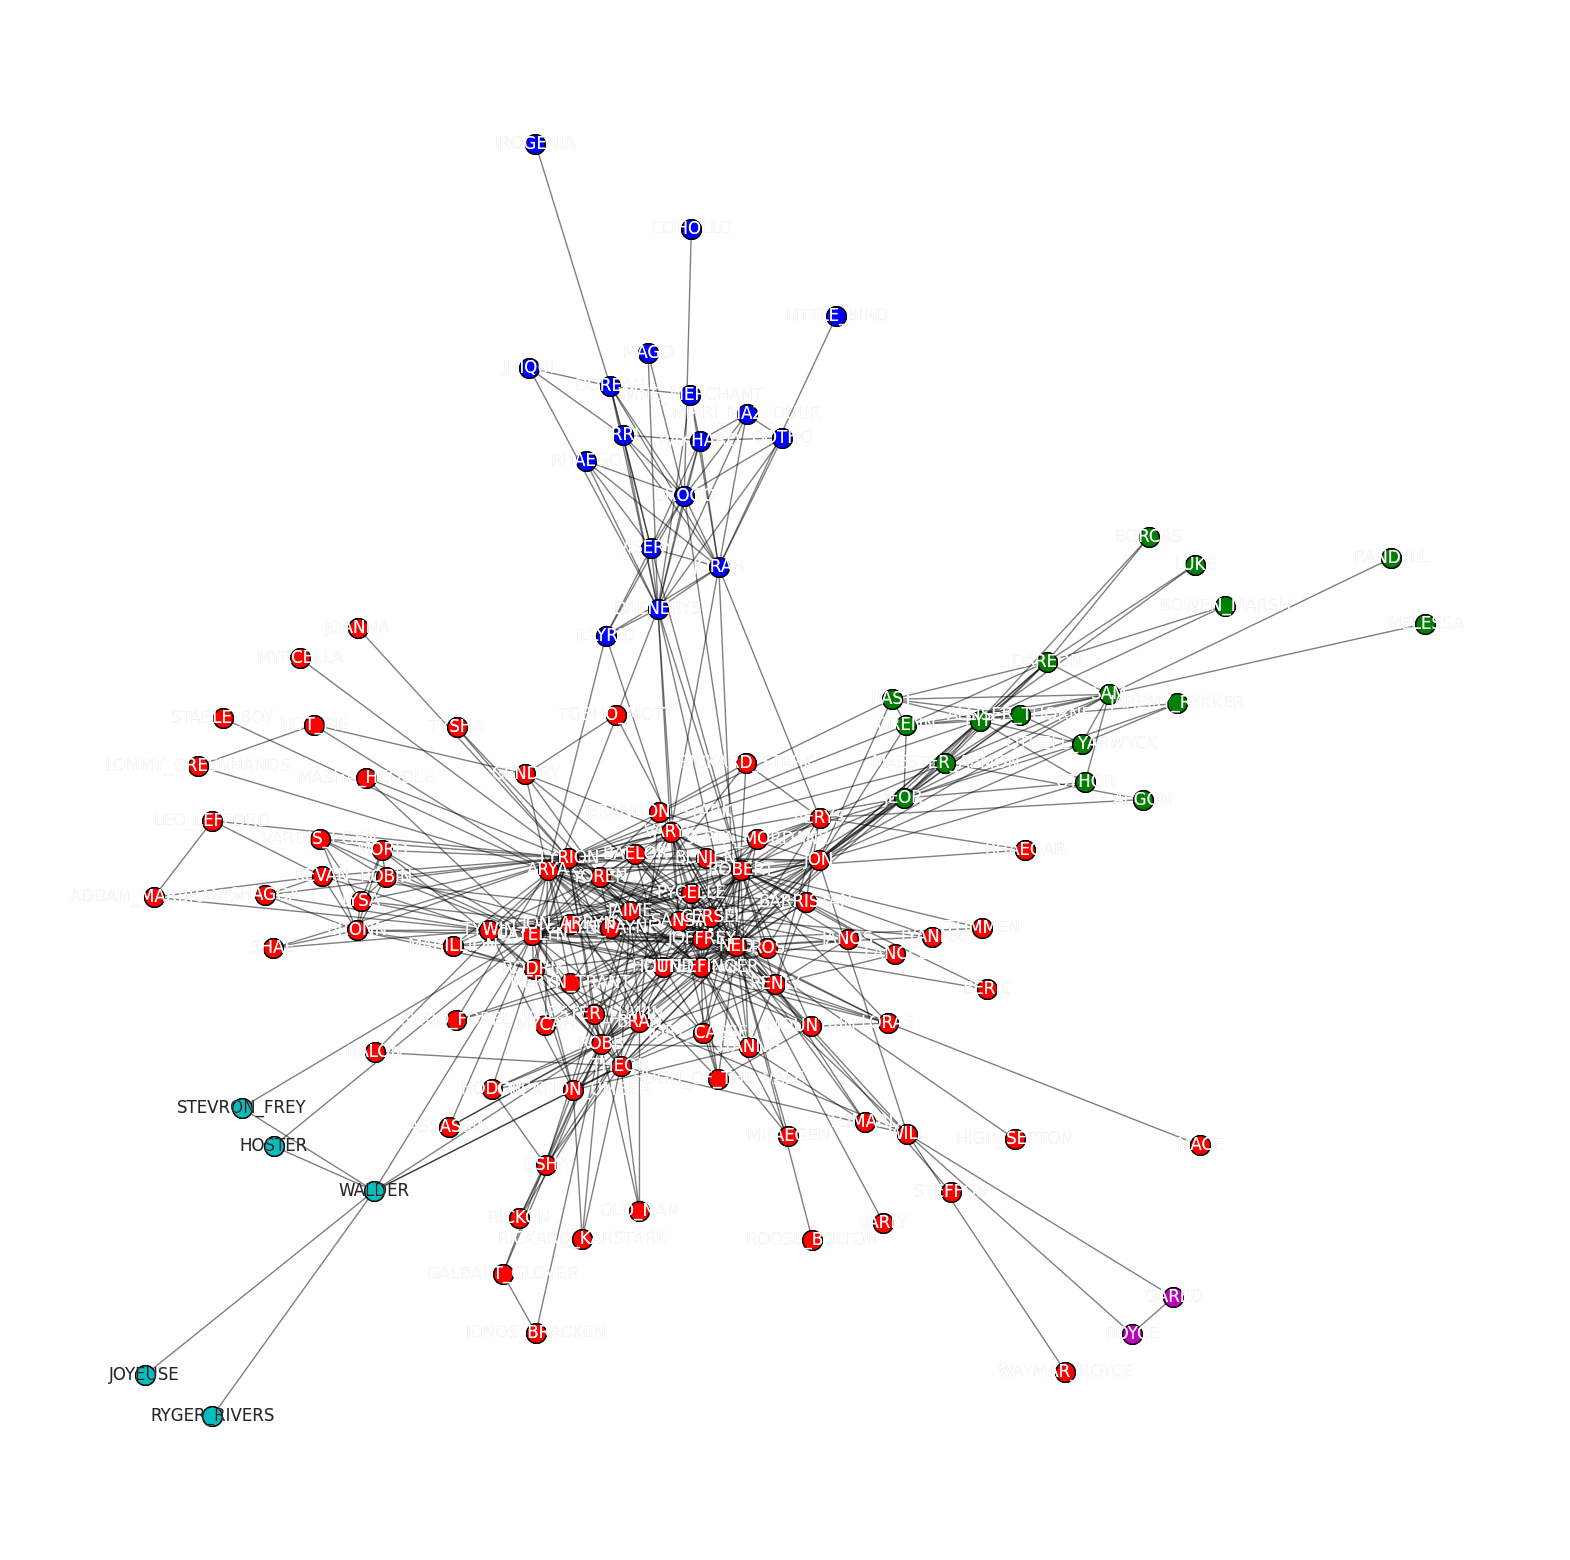

In [ ]:
viz.plot_network_clusters(g, lp_coms, pos, figsize=(20, 20), plot_labels=True)

Such strategy is feasible when the network is small enogh. In case of medium size graphs an alternative is collapsing all community nodes into a single met-node and visualize the resulting community graph:

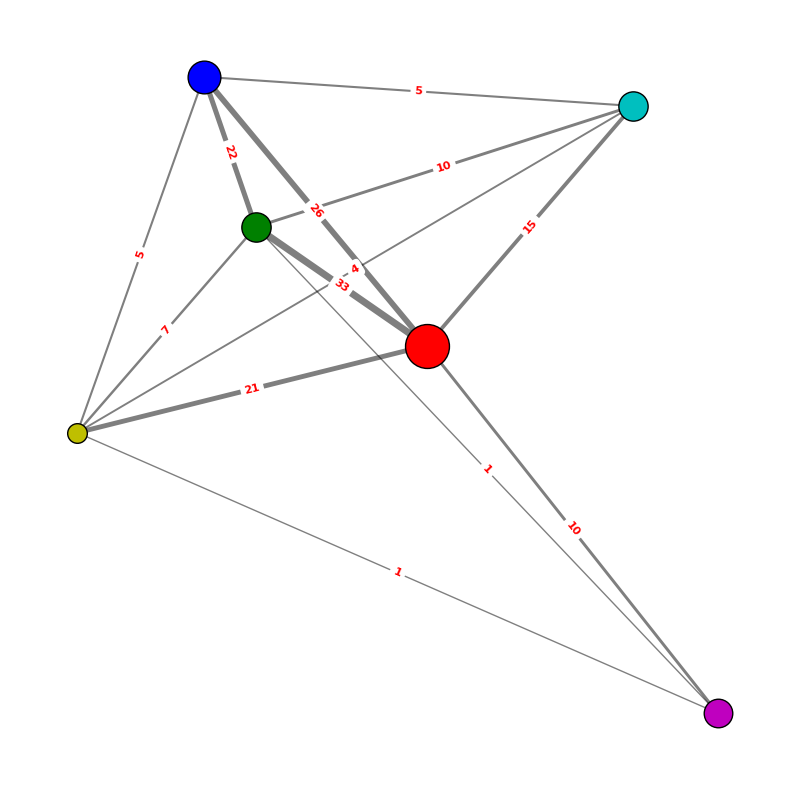

In [ ]:
viz.plot_community_graph(g, leiden_coms, figsize=(10, 10))

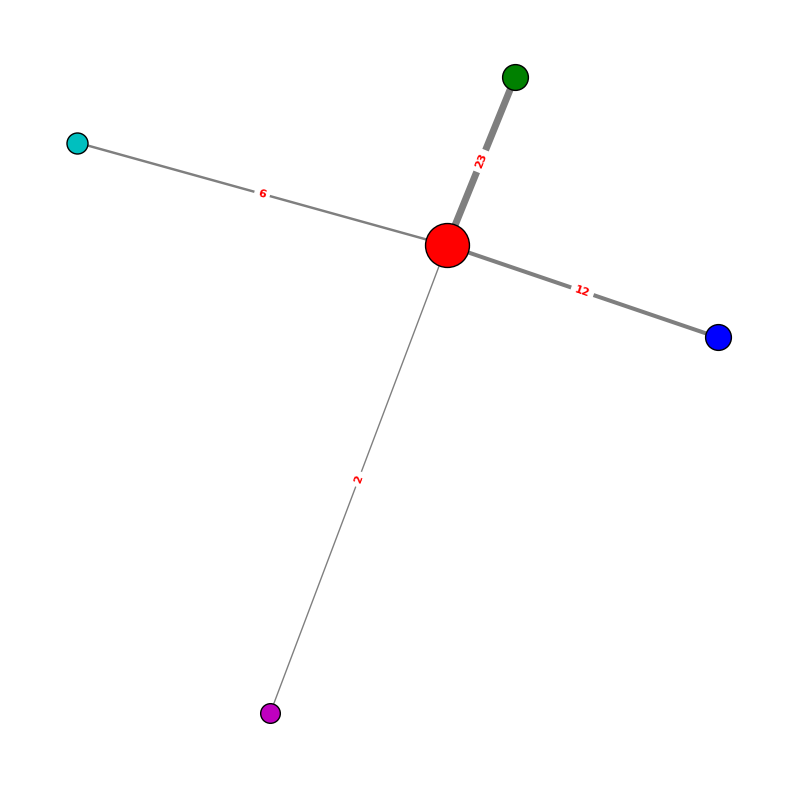

In [ ]:
viz.plot_community_graph(g, lp_coms, figsize=(10, 10))

#### Community fitness/comparison visualization

Given one (or more) clustering it could be useful to visualize how a given fitness function distributes over the communities.

A nice way to do so is by using violin plots.

<Axes: xlabel='Algorithm', ylabel='internal_edge_density'>

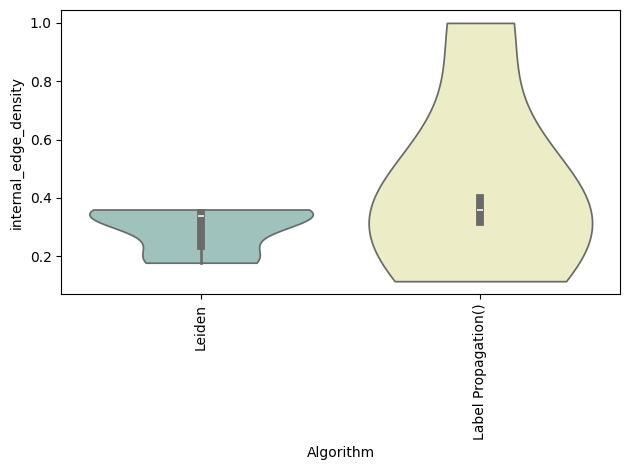

In [ ]:
viz.plot_com_stat([leiden_coms, lp_coms], evaluation.internal_edge_density)

Another simple visualization type that allows getting a few insights on community characteristics is the scatter plot.

We can easily pair-wise compare fitness functions for one or more clustering as follows:

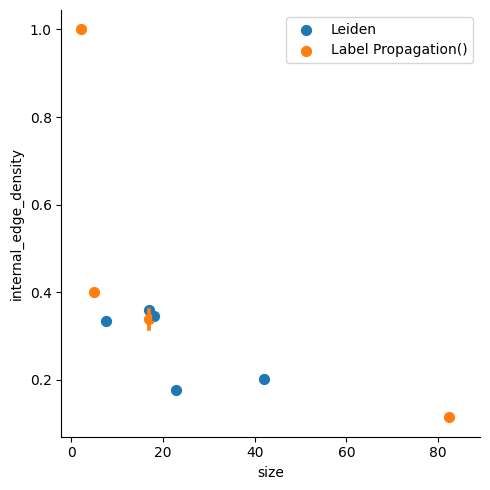

In [ ]:
viz.plot_com_properties_relation([leiden_coms, lp_coms], evaluation.size, evaluation.internal_edge_density)

<a id="qualitative"></a>
### Qualitative evaluation ([to top](#top))

Another way to validate a clustering is to analyse the purity of each community w.r.t. an external attribute.

In our example, let's consider the Houses of GoT characters: what's the CD approach among the tested ones that allows to identify more "homogeneous" clusters?

In [ ]:
def read_houses(filename):
    node_to_house = {}
    with open(filename) as f:
        f.readline()
        for l in f:
            l = l.rstrip().split(",")
            node_to_house[l[0]] = l[2]
    return node_to_house

def community_purity(coms, nth):
    purities = []
    for c in coms.communities:
        houses = []
        for node in c:
            if node in nth:
                houses.append(nth[node])

        cnt = Counter(houses)
        purity = max(cnt.values())/sum(cnt.values())
        purities.append(purity)
    return purities

In [ ]:
# Game of Thrones Houses
nth = read_houses(f'asioaf/got-s{season}-nodes_ext.csv')

In [ ]:
leiden_purities = community_purity(leiden_coms, nth)
leiden_purities

[0.18604651162790697,
 0.391304347826087,
 0.5555555555555556,
 0.5555555555555556,
 0.47058823529411764,
 0.42857142857142855]

In [ ]:
np.mean(leiden_purities), np.std(leiden_purities)

(0.4312702724051085, 0.1252855519446968)

In [ ]:
lp_purities = community_purity(lp_coms, nth)
lp_purities

[0.24705882352941178, 0.47058823529411764, 0.5882352941176471, 0.6, 0.5]

In [ ]:
np.mean(lp_purities), np.std(lp_purities)

(0.48117647058823526, 0.12716770933526267)

<a id="gt"></a>
### Ground Truth evaluation ([to top](#top))

Let assume we want to compare different clusterings over a set of network ground truth partitions.

In order to obtain a more interesting example, we can generate a few synthetic graphs with planted ground truth clusterings and perform CD upon them. <br/> We can easily visually compare their resuls as follows:

<Axes: xlabel='graph', ylabel='score'>

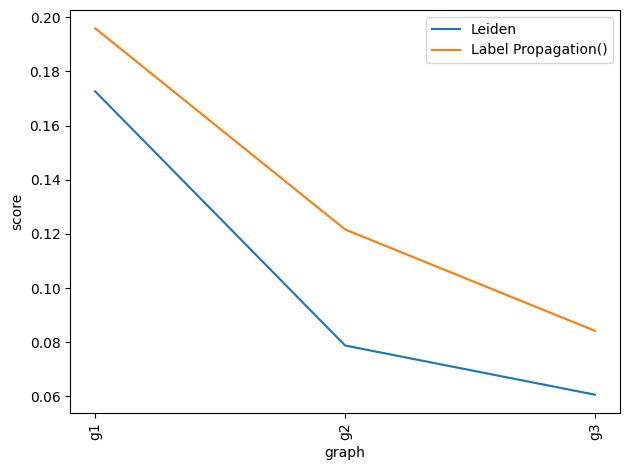

In [ ]:
from cdlib import NodeClustering
from networkx.generators.community import LFR_benchmark_graph

g1 = LFR_benchmark_graph(1000, 3, 1.5, 0.5, min_community=20, average_degree=5)
g2 = LFR_benchmark_graph(1000, 3, 1.5, 0.6, min_community=20, average_degree=5)
g3 = LFR_benchmark_graph(1000, 3, 1.5, 0.7, min_community=20, average_degree=5)

names = ["g1", "g2", "g3"]
graphs = [g1, g2, g3]
references = []

# building the NodeClustering ground truth for the graphs
for g in graphs:
    ground_truth = NodeClustering(communities={frozenset(g.nodes[v]['community']) for v in g}, graph=g, method_name="reference")
    references.append(ground_truth)

algos = [algorithms.leiden, algorithms.label_propagation]

# Computing the visualization (2 execution per method, NMI as scoring for ground truth resemblance)
viz.plot_scoring(graphs, references, names, algos, scoring=evaluation.adjusted_mutual_information, nbRuns=2)

Finally, we can also compare different clustering obtained on the same graph by alternative algorithms among them. <br/>
Let's get back to our initial Karate Club graph and compute a few more clusterings upon it:

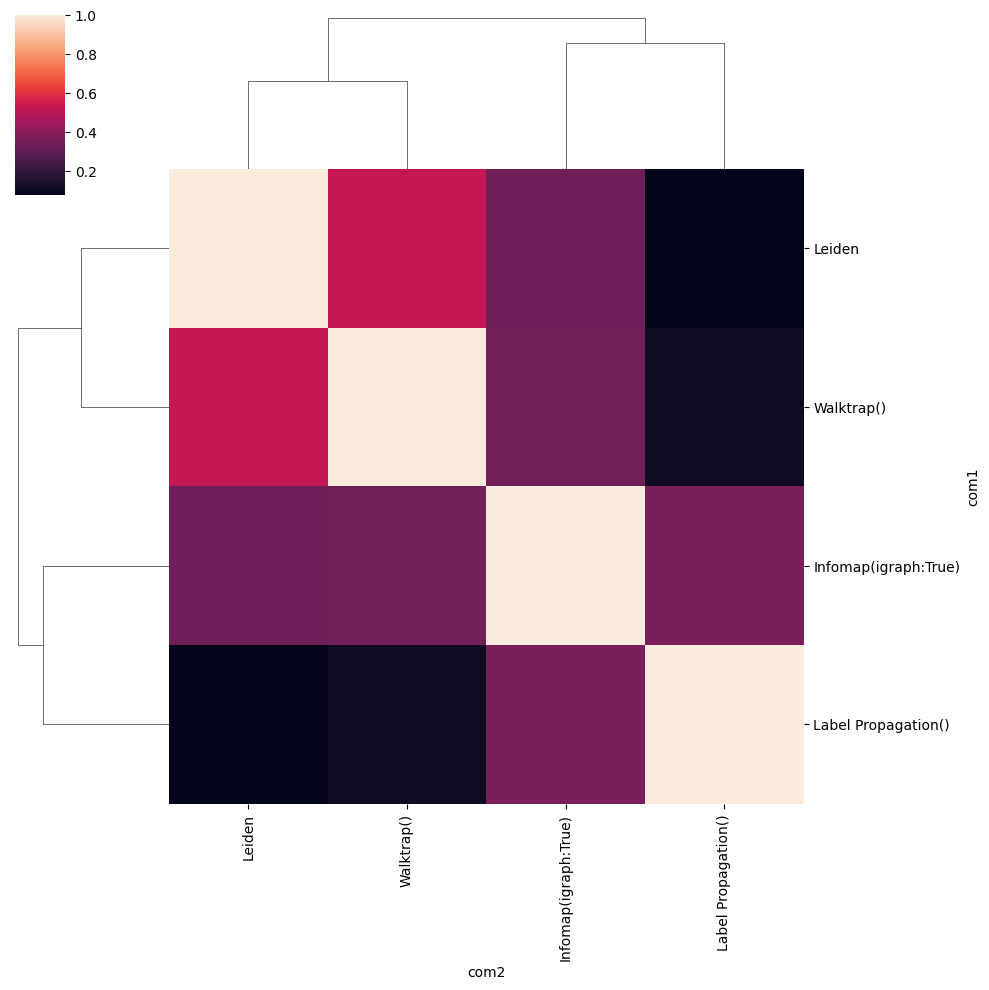

In [ ]:
g = read_net('asioaf/got-s7-edges.csv')

lp_coms = algorithms.label_propagation(g)
leiden_coms = algorithms.leiden(g)
wp_coms = algorithms.walktrap(g)
infomap_coms = algorithms.infomap(g)

viz.plot_sim_matrix([leiden_coms, lp_coms, wp_coms, infomap_coms],evaluation.adjusted_mutual_information)